[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/James-Leslie/deep-collaborative-filtering/blob/master/tf-movielens100k.ipynb)

# To do:
  - try out [this implementation](https://www.onceupondata.com/2019/02/10/nn-collaborative-filtering/) of baseline features. 
  - create object classes for models
  - implement TF 2.0 data classes
  - [paperswithcode link](https://paperswithcode.com/sota/collaborative-filtering-on-movielens-100k)
  - [ML 100k state of the art paper](https://arxiv.org/pdf/1706.02263v2.pdf) (RMSE=0.905): details their evaluation method
  - include genre model in combined grid search

## Best CV score: Unknown (25 : 64 : 0.2)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Add, Dense, Concatenate, Dropout, LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.math import add

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

%matplotlib inline

In [2]:
# path = 'https://raw.githubusercontent.com/James-Leslie/deep-collaborative-filtering/master/data/ml-100k/'  # access from anywhere
path = 'data/ml-100k/'  # if the files are local
# path = 'data/ml-1m/'  # ML-1m file
df = pd.read_csv(path+'ratings.csv', usecols=['userId','movieId','rating'])

In [3]:
df.head()

,userId,movieId,rating
0,0,0,3
1,1,1,3
2,2,2,1
3,3,3,2
4,4,4,1


In [4]:
df.shape

(100000, 3)

In [5]:
print('Number of users:', df.userId.nunique())
print('Number of items:', df.movieId.nunique())
print("Min item rating:", df.rating.min())
print("Max item rating:", df.rating.max())
print("Mean item rating:", df.rating.mean())

Number of users: 943
Number of items: 1682
Min item rating: 1
Max item rating: 5
Mean item rating: 3.52986


# Create baseline features
For each different train / test split, global mean and biases need to be calculated so as to avoid potential data leakage.

In [6]:
def get_baseline(df, train_index, test_index):
    
    '''
    Calculate baseline features from an explicit ratings dataset. Receives a dataframe
    and returns train and test splits with added bias column and mean rating value.
    User and item biases are calculated as average difference from global mean rating.
    Baseline factors are only calculated from training observations, with users or
    items that do not appear in train receiving the global average as default.
    
    Args:
        df          : explicit ratings dataframe with columns userId, movieId and rating
        train_index : train index splits taken from KFold.splits()
        test_index  : test index splits taken from KFold.splits()
        
    Returns:
        train, test : train/test splits of df, with added bias column
        global_mean : average rating of all training observations
    '''
    
    train = df.iloc[train_index]
    test = df.iloc[test_index]
    
    # compute global mean
    global_mean = train.rating.mean()

    # compute average item ratings
    item_averages = train.groupby(
        'movieId'
    ).agg(
        {'rating':'mean'}
    ).rename(
        {'rating': 'item_avg'}, axis=1
    ).reset_index()
    
    # add as column to train and test
    train = pd.merge(train, item_averages, how='left', on='movieId')
    test = pd.merge(test, item_averages, how='left', on='movieId').fillna(global_mean)
    
    # compute average user bias
    train['user_bias'] = train['rating'] - train['item_avg']
    
    user_biases = train.groupby(
        'userId'
    ).agg(
        {'user_bias':'mean'}
    ).rename(
        {'user_bias': 'user_avg'}, axis=1
    ).reset_index()
    
    # add as column to train and test
    train = pd.merge(train, user_biases, how='left', on='userId')
    test = pd.merge(test, user_biases, how='left', on='userId').fillna(0.0)
    
    # interaction bias
    train['bias'] = (train['user_avg'] + train['item_avg'] - global_mean)/2
    test['bias'] = (test['user_avg'] + test['item_avg'] - global_mean)/2
    
    return train, test, global_mean

## Ratings model

In [7]:
def compile_model(n_users, n_items, mean_rating, n_factors=25, n_hidden=64, leaky_alpha=.1, dropout=.2):
    
    # item latent factors
    item_in = Input(shape=[1])  # name='item'
    item_em = Embedding(n_items, n_factors)(item_in)
    item_vec = Flatten()(item_em)
    
    # user latent factors
    user_in = Input(shape=[1])
    user_em = Embedding(n_users, n_factors)(user_in)
    user_vec = Flatten()(user_em)
    
    # user x item bias
    bias = Input(shape=[1])
    
    # if there is a hidden layer
    if n_hidden:
        # concatenate user and item vectors
        conc = Concatenate()([item_vec, user_vec])
        # hidden layer
        hidden = Dense(n_hidden)(conc)
        leaky = LeakyReLU(alpha=leaky_alpha)(hidden)
        drop = Dropout(dropout)(leaky)
        
        out = Dense(1)(drop)
        
    # if there are no hidden layers
    else:
        out = Dot(name="Dot-Product", axes=1)([item_vec, user_vec])
    
    rating = add(Add()([out, bias]), mean_rating)
    
    # create model and compile it
    model = Model([user_in, item_in, bias], rating)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

In [8]:
# hyper parameters
HP_N_FACTORS = [20, 25, 30]
HP_N_HIDDEN = [20, 40, 60]
HP_DROPOUT = [.2, .25]

In [10]:
# dataframe to store results of grid search
grid_results = []
best_loss = 1
searches = 1

n_models = len(HP_N_FACTORS) * len(HP_N_HIDDEN) * len(HP_DROPOUT)

print(f'Fitting total of {n_models} models\n')

for N_FACTORS in HP_N_FACTORS:
    for N_HIDDEN in HP_N_HIDDEN:
        for DROPOUT in HP_DROPOUT:
            
            print(f'Fitting model #{searches} with {N_FACTORS}: {N_HIDDEN} architecture, {DROPOUT} dropout rate')
            searches += 1
            
            # CV split
            # calculate global mean rating and bias
            kf = KFold(n_splits=5)
            
            total_loss, count = 0, 1
            min_epochs = 10
            
            # do CV split and compute baseline predictors
            for train_index, test_index in kf.split(df):
                train, test, global_mean = get_baseline(df, train_index, test_index)
                
                # compile model with chosen h-params
                model = compile_model(
                    n_users = df.userId.nunique(),
                    n_items = df.movieId.nunique(),
                    mean_rating = global_mean,
                    n_factors = N_FACTORS,
                    n_hidden = N_HIDDEN,
                    dropout = DROPOUT
                )

                result = model.fit(x=[train.userId.values, train.movieId.values, train.bias.values],
                                   y=train.rating.values, 
                                   batch_size=512,
                                   epochs=10,
                                   verbose=0,
                                   validation_data=([test.userId.values, test.movieId.values, test.bias.values], test.rating.values))
                
                fold_loss = np.sqrt(np.min(result.history['val_loss']))
                total_loss += fold_loss
                min_epochs = min(np.argmin(result.history['val_loss']) + 1, min_epochs)
                
                print(f'CV split #{count}: RMSE={fold_loss:.4f}')
                count += 1

            avg_loss = total_loss / 5
            best_loss = min(avg_loss, best_loss)
            print(f'_____________________________________CV avg RMSE={avg_loss:.4f}')
            
#             plt.plot(result.history['loss'], label='train')
#             plt.plot(result.history['val_loss'], label='val')
#             plt.axhline(y=best_loss, color='r', lw=1, ls='-')
#             plt.legend()
#             plt.show()
            
            grid_results.append({'n_factors':N_FACTORS,
                                 'n_hidden':N_HIDDEN,
                                 'dropout':DROPOUT,
                                 'val_rmse':avg_loss,
                                 'val_epochs':min_epochs,
                                 'train_hist':result.history['loss'],
                                 'val_hist':result.history['val_loss']})
            print()
            break
        break
#     break

grid_results = pd.DataFrame(data=grid_results, columns=grid_results[0].keys())

Fitting total of 18 models

Fitting model #1 with 20: 20 architecture, 0.2 dropout rate
CV split #1: RMSE=0.9393
CV split #2: RMSE=0.9276
CV split #3: RMSE=0.9289
CV split #4: RMSE=0.9240
CV split #5: RMSE=0.9197
_____________________________________CV avg RMSE=0.9279

Fitting model #2 with 25: 20 architecture, 0.2 dropout rate
CV split #1: RMSE=0.9387
CV split #2: RMSE=0.9270
CV split #3: RMSE=0.9190
CV split #4: RMSE=0.9217
CV split #5: RMSE=0.9205
_____________________________________CV avg RMSE=0.9254

Fitting model #3 with 30: 20 architecture, 0.2 dropout rate
CV split #1: RMSE=0.9390
CV split #2: RMSE=0.9256
CV split #3: RMSE=0.9239
CV split #4: RMSE=0.9231
CV split #5: RMSE=0.9240
_____________________________________CV avg RMSE=0.9271



In [11]:
grid_results.sort_values('val_rmse').head(20)

,n_factors,n_hidden,dropout,val_rmse,val_epochs,train_hist,val_hist
1,25,20,0.2,0.925361,9,"[0.9105374353408814, 0.8609727022171021, 0.841...","[0.8924711002349853, 0.8768342953681946, 0.866..."
2,30,20,0.2,0.927104,10,"[0.9073889507293701, 0.857032315826416, 0.8393...","[0.8895169986724853, 0.8755989328384399, 0.865..."
0,20,20,0.2,0.927911,9,"[0.9129080150604248, 0.8601889047622681, 0.839...","[0.8932844661712647, 0.876846544933319, 0.8666..."


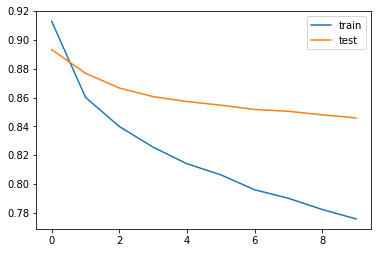

In [12]:
plt.plot(grid_results.iloc[0,-2], label='train')
plt.plot(grid_results.iloc[0,-1], label='test')
plt.legend()
plt.show()

# Genre model

In [13]:
def compile_genre_model(n_items, n_users, mean_rating, n_genres, n_latent, n_hidden_1, n_hidden_2, dropout_1, dropout_2):
    
    # item latent factors
    item_in = Input(shape=[1])  # name='item'
    item_em = Embedding(n_items, n_latent)(item_in)
    item_vec = Flatten()(item_em)
    
    # user latent factors
    user_in = Input(shape=[1])
    user_em = Embedding(n_users, n_latent)(user_in)
    user_vec = Flatten()(user_em)
    
    # user x item bias
    bias = Input(shape=[1])
    
    # concatenate user and item vectors
    conc = Concatenate()([item_vec, user_vec])
    # hidden layer
    hidden_1 = Dense(n_hidden_1)(conc)
    leaky = LeakyReLU(alpha=0.1)(hidden_1)
    drop_1 = Dropout(dropout_1)(leaky)
    
    out = Dense(1)(drop_1)
            
    rating = add(Add()([out, bias]), mean_rating)
    
    # create model and compile it
    model = Model([user_in, item_in, bias], rating)
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # model 2
    hidden_2 = Dense(n_hidden_2, activation='relu')(item_vec)
    drop_2 = Dropout(dropout_2)(hidden_2)
    genre = Dense(n_genres, activation='sigmoid')(drop_2)  # there are 18 genres

    # Create model and compile it
    model2 = Model(item_in, genre)
    # freeze the embedding layer
    model2.layers[1].trainable = False
    model2.compile(optimizer='adam', loss='binary_crossentropy' , metrics=['accuracy'])
    
    return model, model2

In [14]:
movies = pd.read_csv(path+'movies.csv')
movies.head()

,movieId,title,releaseDate,link,unknown,Action,Adventure,Animation,Children's,Comedy,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,24,Toy Story (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,147,GoldenEye (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,233,Four Rooms (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,47,Get Shorty (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,75,Copycat (1995),01-Jan-1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [15]:
train, _, _ = get_baseline(df, df.index, df.index)

model1, model2 = compile_genre_model(
    n_items = df.movieId.nunique(),
    n_users = df.userId.nunique(),
    mean_rating = df.rating.mean(), 
    n_genres=18,
    n_latent=25, 
    n_hidden_1=32,
    n_hidden_2=64,
    dropout_1=.2,
    dropout_2=.2
)

ratings = model1.fit(
    x=[train.userId.values, train.movieId.values, train.bias.values],
    y=train.rating.values, 
    batch_size=256,
    epochs=10,
    verbose=1,
    validation_split=.2
)

W0926 15:46:12.928670  5420 training.py:1952] Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?


Train on 80000 samples, validate on 20000 samples
Epoch 1/10
80000/80000 [==============================] - 1s 10us/sample - loss: 0.9026 - val_loss: 0.8643
Epoch 2/10
80000/80000 [==============================] - 1s 7us/sample - loss: 0.8525 - val_loss: 0.8522
Epoch 3/10
80000/80000 [==============================] - 1s 7us/sample - loss: 0.8320 - val_loss: 0.8465
Epoch 4/10
80000/80000 [==============================] - 1s 7us/sample - loss: 0.8165 - val_loss: 0.8403
Epoch 5/10
80000/80000 [==============================] - 1s 7us/sample - loss: 0.8040 - val_loss: 0.8382
Epoch 6/10
80000/80000 [==============================] - 1s 7us/sample - loss: 0.7906 - val_loss: 0.8357
Epoch 7/10
80000/80000 [==============================] - 1s 7us/sample - loss: 0.7765 - val_loss: 0.8334
Epoch 8/10
80000/80000 [==============================] - 1s 7us/sample - loss: 0.7615 - val_loss: 0.8274
Epoch 9/10
80000/80000 [==============================] - 1s 7us/sample - loss: 0.7486 - val_loss: 0.

In [16]:
genres = model2.fit(
    movies.movieId.values, movies.iloc[:,-18:].values,
    batch_size=64, 
    epochs=5,
    validation_split=.2)

W0926 15:47:31.388895  5420 deprecation.py:323] From C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 1345 samples, validate on 337 samples
Epoch 1/5
1345/1345 [==============================] - 0s 225us/sample - loss: 0.6832 - accuracy: 0.6327 - val_loss: 0.6643 - val_accuracy: 0.8597
Epoch 2/5
1345/1345 [==============================] - 0s 26us/sample - loss: 0.6482 - accuracy: 0.8565 - val_loss: 0.6221 - val_accuracy: 0.9255
Epoch 3/5
1345/1345 [==============================] - 0s 24us/sample - loss: 0.5999 - accuracy: 0.8983 - val_loss: 0.5598 - val_accuracy: 0.9278
Epoch 4/5
1345/1345 [==============================] - 0s 25us/sample - loss: 0.5335 - accuracy: 0.9019 - val_loss: 0.4798 - val_accuracy: 0.9273
Epoch 5/5
1345/1345 [==============================] - 0s 25us/sample - loss: 0.4579 - accuracy: 0.9020 - val_loss: 0.3972 - val_accuracy: 0.9268


In [17]:
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [18]:
y_true = movies.iloc[:,-18:]
y_score = pd.DataFrame(model2.predict(movies.movieId.values), columns=y_true.columns)
y_pred = y_score.round().astype('int')

In [19]:
drama_true = y_true.Drama
drama_pred = y_pred.Drama

In [20]:
print(classification_report(drama_true, drama_pred))

              precision    recall  f1-score   support

           0       0.62      0.81      0.71       957
           1       0.59      0.36      0.44       725

   micro avg       0.62      0.62      0.62      1682
   macro avg       0.61      0.58      0.58      1682
weighted avg       0.61      0.62      0.59      1682



In [21]:
pd.DataFrame(confusion_matrix(drama_true, drama_pred))

,0,1
0,778,179
1,467,258


In [23]:
print(classification_report(y_true, y_pred, target_names=y_true.columns))

              precision    recall  f1-score   support

      Action       0.00      0.00      0.00       251
   Adventure       0.00      0.00      0.00       135
   Animation       0.00      0.00      0.00        42
  Children's       0.00      0.00      0.00       122
      Comedy       0.00      0.00      0.00       505
       Crime       0.00      0.00      0.00       109
 Documentary       0.00      0.00      0.00        50
       Drama       0.59      0.36      0.44       725
     Fantasy       0.00      0.00      0.00        22
   Film-Noir       0.00      0.00      0.00        24
      Horror       0.00      0.00      0.00        92
     Musical       0.00      0.00      0.00        56
     Mystery       0.00      0.00      0.00        61
     Romance       0.00      0.00      0.00       247
      Sci-Fi       0.00      0.00      0.00       101
    Thriller       0.00      0.00      0.00       251
         War       0.00      0.00      0.00        71
     Western       0.00    

C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\JLeslie\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined a